In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load

import datetime

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import statistics
from scipy.stats import stats
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time


In [2]:
# Load X and y values
X = load('Obs_NormX.joblib') 
#X

y= load('Obs_y.joblib')
#y

In [3]:
# Hyperparameter tuning

In [4]:
svReg = SVR()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'kernel':[ 'rbf','poly' ,'sigmoid'  ],
              'gamma': ['scale', 'auto'],
              'C': [1,2,3,4,5,6],
              }

# run grid search
grid_search = GridSearchCV(svReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 61.32 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.323 (std: 0.151)
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.322 (std: 0.152)
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.293 (std: 0.160)
Parameters: {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}



Accuracy of base SVR model is , 0.7634788798650556


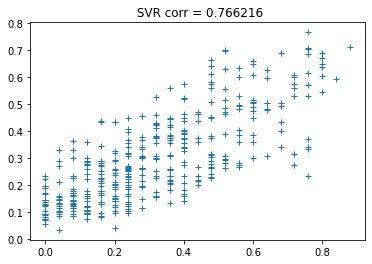

In [5]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 1, gamma='scale', kernel= 'rbf')
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(y_test,yy_test,'+')

# test on 2011-2018 Data

In [6]:
Xt = load('Obs_NormX_1980-1983_2015-2018.joblib') 
#X

yt= load('Obs_y_1980-1983_2015-2018.joblib')
#y
#y

In [7]:
regLin=SVR().fit(X, y)


Accuracy of base SVR model is , 0.7010706098532444


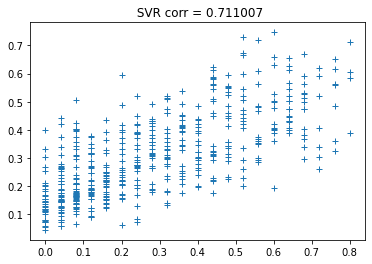

In [8]:
yPred = regLin.predict(Xt)
testcorr = np.corrcoef(yPred,yt)[0,1]
acc_svr       = round(regLin.score(Xt, yt) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
plt.title(' SVR corr = %f'%testcorr)
plt.plot(yt,yPred,'+')

# Fog Statistics 

In [9]:
y

<xarray.DataArray 'fogdata' (time: 1922)>
array([0.16, 0.28, 0.32, ..., 0.76, 0.72, 0.76])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2014-12-31

In [10]:
yLR=regLin.predict(X)

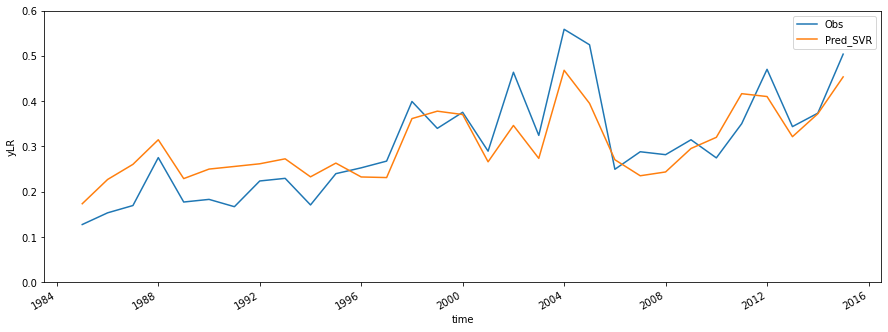

In [11]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataSVR.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_SVR')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_SVR.jpeg',dpi=300)

In [12]:
ynf=y.where(y==0, drop=True)
ynf

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)

yWd=y.where(y>0.44, drop=True)
yWd

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)

yint1=y.where(y>0,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
yintf

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>0.039,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)

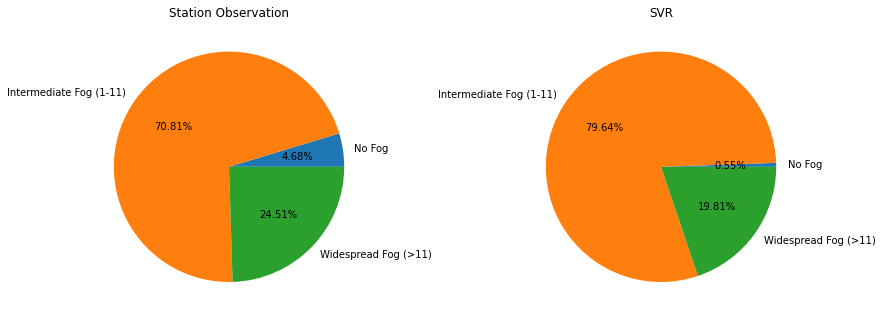

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('SVR')
plt.show()

In [14]:
pie1dataSVR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
dump(pie1dataSVR,'pie1dataSVR.joblib')

['pie1dataSVR.joblib']

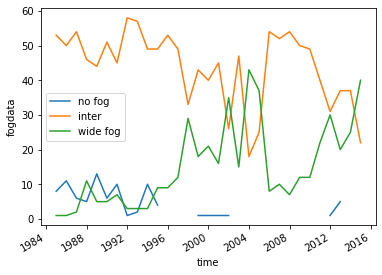

In [15]:
ynf.resample(time='1Y').count().plot(label='no fog')
yintf.resample(time='1Y').count().plot(label='inter')
yWd.resample(time='1Y').count().plot(label='wide fog')
plt.legend()

In [16]:
noFogCounts=np.nan_to_num(ynf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
interFogCounts=yintf.resample(time='1Y').count()
wdFogCounts=yWd.resample(time='1Y').count()


#noFogCountsLR=np.nan_to_num(yLRnf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
noFogCountsLR=0
interFogCountsLR=yLRintf.resample(time='1Y').count()
wdFogCountsLR=np.nan_to_num(yLRWd.yLR.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)

In [17]:
wdFogCountsLR

array([ 2,  3,  5, 18,  4,  9,  9,  1,  3,  2,  6,  7,  4, 21, 25, 23, 10,
       23,  9, 34, 24,  5,  3,  1,  9,  8, 29, 28, 16, 19, 39])

Text(0.5, 1.0, 'SVR')

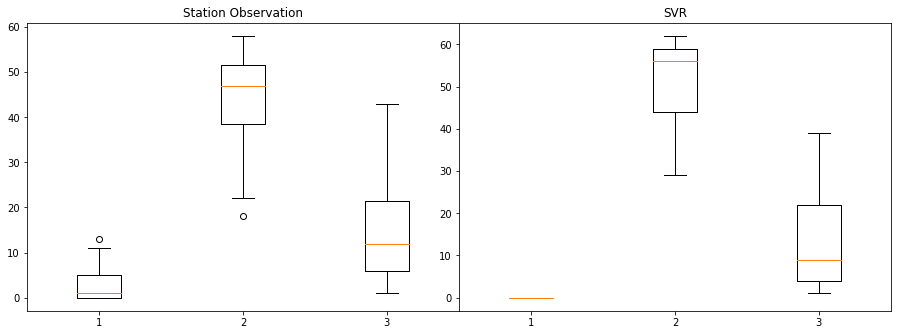

In [18]:
data = [noFogCounts, interFogCounts, wdFogCounts]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot(data)
ax.set_title('Station Observation')

dataLR = [noFogCountsLR, interFogCountsLR.yLR, wdFogCountsLR]
ax1 = fig.add_axes([1,0,1,1])
ax1.boxplot(dataLR)
ax1.set_title('SVR')

# Test Data 2015-2018

In [19]:
yLRt=regLin.predict(Xt)

In [20]:
#dump(yLRt,'TS2dataSVR.joblib')

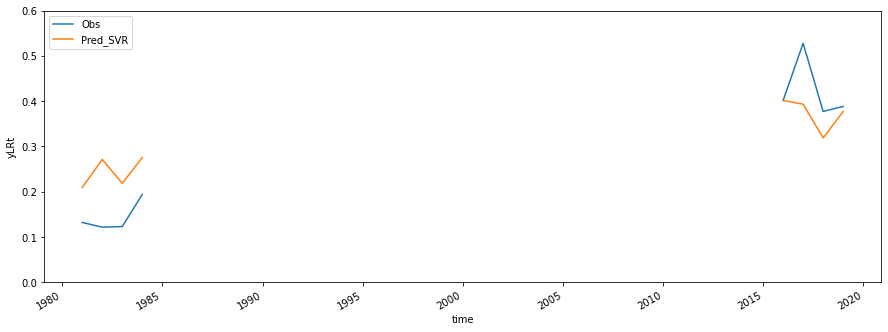

In [21]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt)}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataSVR.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_SVR')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_SVR_2015-2018.jpeg',dpi=300)

In [22]:
ynft=yt.where(yt==0, drop=True)
ynft

yWdt=yt.where(yt>0.44, drop=True)
yWdt

yint1t=yt.where(yt>0,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
yintft

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>0.44,drop=True)
yLRWdt

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>0.039,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
yLRintft

<xarray.Dataset>
Dimensions:  (time: 424)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
Data variables:
    yLRt     (time) float64 0.2797 0.1974 0.3885 0.409 ... 0.131 0.4141 0.4346

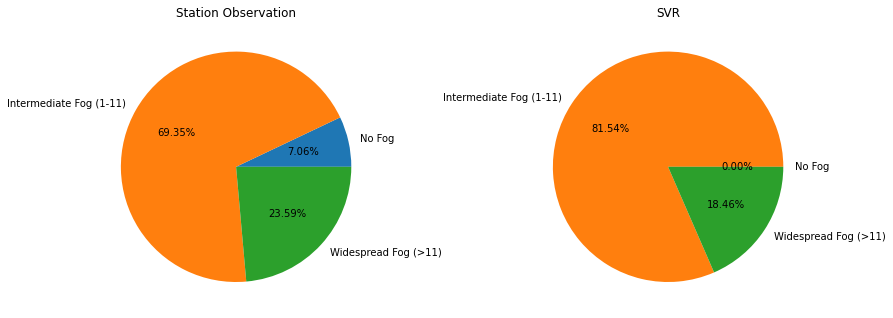

In [23]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('SVR')
plt.show()




In [24]:
pie1dataSVR = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
dump(pie1dataSVR,'pie2dataSVR.joblib')

['pie2dataSVR.joblib']